<a href="https://colab.research.google.com/github/bonochof/rl-maze/blob/master/Q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

強化学習（Q学習）
===
Author: Ryosuke TAKATA (Shizuoka University)

#### 手順1: 基本ライブラリを読み込む

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 手順2: 環境を作成する

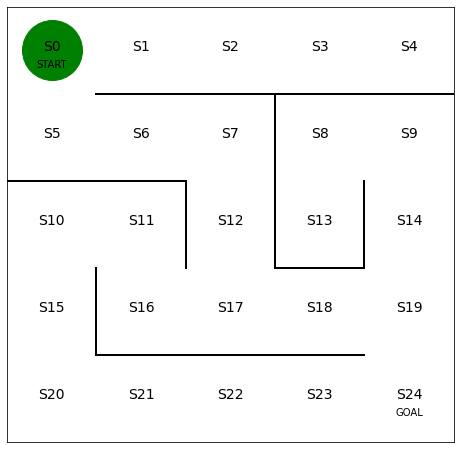

In [2]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()

# 状態を割り当て
FIELD_SIZE = 5
for y in range(FIELD_SIZE):
  for x in range(FIELD_SIZE):
    plt.text(x + 0.5, 4.5 - y, 'S{}'.format(x + y * 5), size=14, ha='center')

# 迷路の壁を作成
plt.plot([1, 5], [4, 4], color='black', linewidth=2)
plt.plot([0, 2], [3, 3], color='black', linewidth=2)
plt.plot([3, 3], [4, 2], color='black', linewidth=2)
plt.plot([4, 4], [3, 2], color='black', linewidth=2)
plt.plot([3, 4], [2, 2], color='black', linewidth=2)
plt.plot([1, 4], [1, 1], color='black', linewidth=2)
plt.plot([2, 2], [3, 2], color='black', linewidth=2)
plt.plot([1, 1], [2, 1], color='black', linewidth=2)

# スタート位置とゴール位置を設定
START = 0
GOAL = 24
plt.text(START % 5 + 0.5, 4.3 - int(START / 5), 'START', ha='center')
plt.text(GOAL % 5 + 0.5, 4.3 - int(GOAL / 5), 'GOAL', ha='center')

# マップの枠を設定
ax.set_xlim(0, FIELD_SIZE)
ax.set_ylim(0, FIELD_SIZE)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# エージェントの位置を設定
line, = ax.plot([START % 5 + 0.5], [4.5 - int(START / 5)], marker="o", color='g', markersize=60)

#### 手順3: 初期方策を作成する

In [3]:
theta_0 = np.array([[np.nan,      1,      1, np.nan], # S0
                    [np.nan,      1, np.nan,      1], # S1
                    [np.nan,      1, np.nan,      1], # S2
                    [np.nan,      1, np.nan,      1], # S3
                    [np.nan, np.nan, np.nan,      1], # S4
                    [     1,      1, np.nan, np.nan], # S5
                    [np.nan,      1, np.nan,      1], # S6
                    [np.nan, np.nan,      1,      1], # S7
                    [np.nan,      1,      1, np.nan], # S8
                    [np.nan, np.nan,      1,      1], # S9
                    [np.nan,      1,      1, np.nan], # S10
                    [np.nan, np.nan,      1,      1], # S11
                    [     1, np.nan,      1, np.nan], # S12
                    [     1, np.nan, np.nan, np.nan], # S13
                    [     1, np.nan,      1, np.nan], # S14
                    [     1, np.nan,      1, np.nan], # S15
                    [     1,      1, np.nan, np.nan], # S16
                    [     1,      1, np.nan,      1], # S17
                    [np.nan,      1, np.nan,      1], # S18
                    [     1, np.nan,      1,      1], # S19
                    [     1,      1, np.nan, np.nan], # S20
                    [np.nan,      1, np.nan,      1], # S21
                    [np.nan,      1, np.nan,      1], # S22
                    [np.nan,      1, np.nan,      1], # S23
                    [     1, np.nan, np.nan,      1], # S24
                    ])

In [4]:
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1

In [5]:
def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    
    pi = np.nan_to_num(pi)
    
    return pi

In [6]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.5        0.         0.5       ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.         1.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.         0.5        0.5        0.        ]
 [0.         0.         0.5        0.5       ]
 [0.         0.5        0.5        0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.         0.5        0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.         0.5        0.         0.5       ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.5        0.5        0.         0.        ]
 [0.         

#### 手順4: 強化学習の処理群を作成する

In [7]:
def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        next_direction = direction[np.nanargmax(Q[s, :])]
    
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3
    
    return action

In [8]:
def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]
    
    if next_direction == "up":
        s_next = s - FIELD_SIZE
    elif next_direction == "right":
        s_next = s + 1
    elif next_direction == "down":
        s_next = s + FIELD_SIZE
    elif next_direction == "left":
        s_next = s - 1
    
    return s_next

In [9]:
def Q_learning(s, a, r, s_next, Q, eta, gamma):
    if s_next == GOAL:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])
    
    return Q

In [10]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = START
    a = a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [[START, np.nan]]
    
    while (1):
        a = a_next
        
        s_a_history[-1][1] = a
        
        s_next = get_s_next(s, a, Q, epsilon, pi)
        
        s_a_history.append([s_next, np.nan])
        
        if s_next == GOAL:
            # ゴールの報酬
            r = 1
            a_next = np.nan
        else:
            # 移動のコスト
            r = -0.05
            a_next = get_action(s_next, Q, epsilon, pi)
        
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)
        
        if s_next == GOAL:
            break
        else:
            s = s_next
        
    return [s_a_history, Q]

#### 手順5: 強化学習を実行する

In [11]:
eta = 0.1
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

V = []
V.append(np.nanmax(Q, axis=1))

while is_continue:
    print("Episode: " + str(episode))
    
    epsilon = epsilon / 2

    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    
    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    v = new_v
    V.append(v)
    
    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")
    
    episode = episode + 1
    if episode > 100:
        break

Episode: 1
0.4773369512568889
迷路を解くのにかかったステップ数は116です
Episode: 2
0.396796404429455
迷路を解くのにかかったステップ数は82です
Episode: 3
0.14013698931588597
迷路を解くのにかかったステップ数は38です
Episode: 4
0.212152797240921
迷路を解くのにかかったステップ数は50です
Episode: 5
0.18885136371090436
迷路を解くのにかかったステップ数は42です
Episode: 6
0.15131250293087492
迷路を解くのにかかったステップ数は26です
Episode: 7
0.14353521539879943
迷路を解くのにかかったステップ数は26です
Episode: 8
0.15970167200163546
迷路を解くのにかかったステップ数は34です
Episode: 9
0.15609463886814223
迷路を解くのにかかったステップ数は34です
Episode: 10
0.1463697863546392
迷路を解くのにかかったステップ数は30です
Episode: 11
0.1252853424384164
迷路を解くのにかかったステップ数は24です
Episode: 12
0.10613564854974358
迷路を解くのにかかったステップ数は16です
Episode: 13
0.11758210376408122
迷路を解くのにかかったステップ数は22です
Episode: 14
0.13531205479138392
迷路を解くのにかかったステップ数は32です
Episode: 15
0.1076891740588943
迷路を解くのにかかったステップ数は20です
Episode: 16
0.10412203805943587
迷路を解くのにかかったステップ数は18です
Episode: 17
0.0974545915278398
迷路を解くのにかかったステップ数は16です
Episode: 18
0.10686886232203827
迷路を解くのにかかったステップ数は22です
Episode: 19
0.09374927599378574
迷路を解くのにかかったステ

#### 手順6: 結果を確認する

In [12]:
print(s_a_history)

[[0, 2], [5, 1], [6, 1], [7, 2], [12, 2], [17, 1], [18, 1], [19, 2], [24, nan]]


In [13]:
# 軌道のプロット

from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    state = s_a_history[i][0]
    x = (state % 5) + 0.5
    y = 4.5 - int(state / 5)
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=True)

HTML(anim.to_jshtml())

In [14]:
# 状態価値のプロット
# （実行に5分ほどかかります）

from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    for y in range(FIELD_SIZE):
      for x in range(FIELD_SIZE):
        line, = ax.plot([x + 0.5], [4.5 - y], marker="s", color=cm.jet(V[i][x + y * 5]), markersize=85)
    line, = ax.plot([GOAL % 5 + 0.5], [4.5 - int(GOAL / 5)], marker="s", color=cm.jet(1.0), markersize=85)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=50, repeat=True)

HTML(anim.to_jshtml())